In [2]:
import polars as pl
from sklearn.ensemble import HistGradientBoostingClassifier
from datetime import datetime
import numpy as np
import geopandas as gpd
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import RidgeClassifier
from cat_model_utils import run_model, get_cat_dict, classify_results, plot_ternary, plot_binary

publication strategy is to compare what sorts of models work. To that end we will
Start with a baseline model based on case rates lagged n months XXX
Add in variables and record improvement/change XXXX
correlated municipios
climatic variables (e.g. surface runoff, temperature) XXXX
socioeconomic variables (eg population, income) XXXX
el nino XXXX
land use variables XXXX
do this for n in [1-3]
aggregate to microregions for comparability to other models
may also include auto correlation by
creating autocorrelation vectors with 24 month lag for each municipio
clustering these vectors
creating a categorical one hot variable for cluster membership

### Load all data

In [3]:
##Load categorical land cover data, it is saved in a tricky format so we need to do some processing, converting list of [[band, value]...] to columns of band - proportion of area
band_names = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_scrub', 'built', 'bare', 'snow_ice']
land_use = (
    pl.read_csv('../data/land_use/dynamic_earth_all_munis_2017.csv')
    .with_columns(
        pl.col('histogram')
        .str.extract_all(
            r'\s[0-9]*\.[0-9]*'
        )
        .list.eval(pl.element().str.strip_chars())
        .cast(pl.List(pl.Float32))
    )
    .with_columns(
        pl.col('histogram').list.sum().alias('total_pixels'),
        pl.col('histogram').list.to_struct(fields=band_names)
    )
    .unnest('histogram')
    .with_columns(
        [pl.col(band)/(pl.col('total_pixels'))for band in band_names],
    )
    .select(pl.exclude('total_pixels'))
    .rename({'CD_MUN':'muni_id'})
)


In [4]:
#Load El nino data, cast and rename for join compatibility
el_nino = pl.read_csv('../data/sst/sst_indices.csv').rename({'YR': 'year', 'MON': 'month'}).with_columns(pl.col('year').cast(str), pl.col('month').cast(pl.UInt32))

In [5]:
#Load monthly dengue case counts -- Note, dengue download script has been updated, you can possibly just run this with a simple read_parquet
#monthly cases are aggregated from the start of the month forward, environmental parameters from the end of the month backwards
monthly_cases = (
    pl.read_parquet('../data/cases/agged/dengue_per_month.parquet')
                 .with_columns(pl.col('DT_NOTIFIC').dt.offset_by('1mo').alias('end_date'))
                 .with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64))
                 .sort('DT_NOTIFIC')
                 .rename({
                    'DT_NOTIFIC': 'start_date',
                    'ID_MUNICIP': 'muni_id'
                    })
)

#We also want to fill out all municipios for which we have no cases pre the training cutoff 2018-01-01

no_cases = (
    monthly_cases
    .filter(pl.col('start_date')<datetime(2018,1,1))
    .with_columns(pl.col('count').sum().over('muni_id').alias('count_sum'))
    .filter(pl.col('count_sum')!=0)
    .select(pl.col('muni_id')).unique().to_series()
)

monthly_cases = monthly_cases.filter(pl.col('muni_id').is_in(no_cases))


In [6]:
#Load google earth engine dynamic exports
monthly_params = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet')

In [7]:
#load municipio polygons, used in plotting later
munis = gpd.read_file('../data/brazil/munis/munis_simple.shp').astype({'CD_MUN': 'string'})
munis['CD_MUN'] = munis['CD_MUN'].str.slice(stop=-1).astype(int)

In [8]:
#join datasets
all_data = (
    monthly_cases.join(monthly_params, how='inner', on=['muni_id', 'end_date']).with_columns(pl.col('end_date').alias('month').dt.month())
    .join(el_nino, how='left', on=['year', 'month'])
    .join(land_use, how='left', on='muni_id')
)

## Tests
Note: we have random_state set for all models. Disable or change this for different results

In [27]:
#Dictionary to hold base results from two model types
MODEL_RESULTS = {}

#Dictionary to hold case lookback results
LOOKBACK_RESULTS = {}

#Dictionary to hold environmental feature results
ENV_RESULTS = {}

#We are going to be exploring case lags 1-4
LAGS = [1,2,3,4]

#We are also exploring the different cat_fns
CAT_DICT = get_cat_dict()

#Common vars for experiments
TRAIN_START = '2005-01-01'
TRAIN_END = '2018-01-01'
TEST_END = '2020-01-01'

##### 1. Ridge Regression Classification using Binary/Ternary and Simple/Relative - Most basic classification model (linear least squares regression)

In [32]:
#Running results for binary/ternary and simple relatives over case lags 1-4
MODEL_RESULTS['ridge_regression'] = {cat_style: dict() for cat_style in CAT_DICT.keys()}
for cat_style, cat_fn in CAT_DICT.items():
    for lag in LAGS:
        clf = RidgeClassifier(random_state=42)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=cat_fn,
            cat_style=cat_style, 
            case_lag=lag
        )
        MODEL_RESULTS['ridge_regression'][cat_style][lag] = results

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    118016
         1.0       0.05      0.00      0.00      6662
         2.0       0.00      0.00      0.00      4946

    accuracy                           0.91    129624
   macro avg       0.32      0.33      0.32    129624
weighted avg       0.83      0.91      0.87    129624



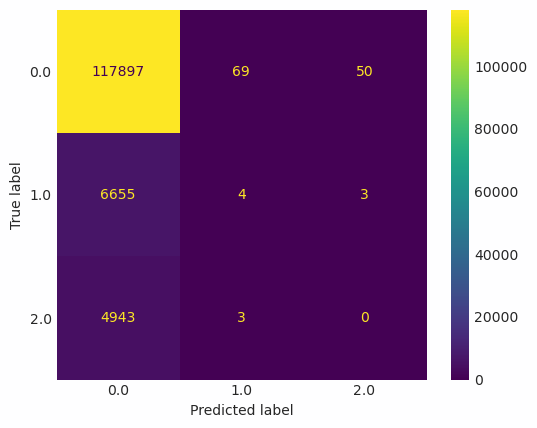

In [33]:
#Check the last results
res = classify_results(results['results'])

In [34]:
#See How MODEL_RESULTS is organized
MODEL_RESULTS['ridge_regression']
#MODEL_RESULTS[experiment_label][cat_style][case_lag]

# Note: because of inconsistencies between list columns in 
# different experiments we do not combine them all into one 
# dataframe, that can be done later

{'relative_ternary': {1: {'results': shape: (129_624, 12)
   ┌────────────┬────────────┬────────────┬─────────┬───┬──────────┬─────────┬────────────┬───────────┐
   │ prediction ┆ ground_tru ┆ date       ┆ muni_id ┆ … ┆ case_lag ┆ env_lag ┆ specific_c ┆ specific_ │
   │ s          ┆ th         ┆ ---        ┆ ---     ┆   ┆ ---      ┆ ---     ┆ ases       ┆ env       │
   │ ---        ┆ ---        ┆ date       ┆ i64     ┆   ┆ i64      ┆ i64     ┆ ---        ┆ ---       │
   │ f64        ┆ f64        ┆            ┆         ┆   ┆          ┆         ┆ list[null] ┆ list[null │
   │            ┆            ┆            ┆         ┆   ┆          ┆         ┆            ┆ ]         │
   ╞════════════╪════════════╪════════════╪═════════╪═══╪══════════╪═════════╪════════════╪═══════════╡
   │ 0.0        ┆ 0.0        ┆ 2018-01-01 ┆ 110001  ┆ … ┆ 1        ┆ 0       ┆ [null]     ┆ [null]    │
   │ 0.0        ┆ 0.0        ┆ 2018-01-01 ┆ 110002  ┆ … ┆ 1        ┆ 0       ┆ [null]     ┆ [null]    │
   │ 0

##### 2. Classification using Gradient Boosting Classifier

In [35]:
#Running results for binary/ternary and simple relatives over case lags 1-4
MODEL_RESULTS['gradient_boosting'] = {cat_style: dict() for cat_style in CAT_DICT.keys()}
for cat_style, cat_fn in CAT_DICT.items():
    for lag in LAGS:
        clf = HistGradientBoostingClassifier(categorical_features=['month'], random_state=42, max_iter=1000)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=cat_fn,
            cat_style=cat_style,
            case_lag=lag
        )
        MODEL_RESULTS['gradient_boosting'][cat_style][lag] = results

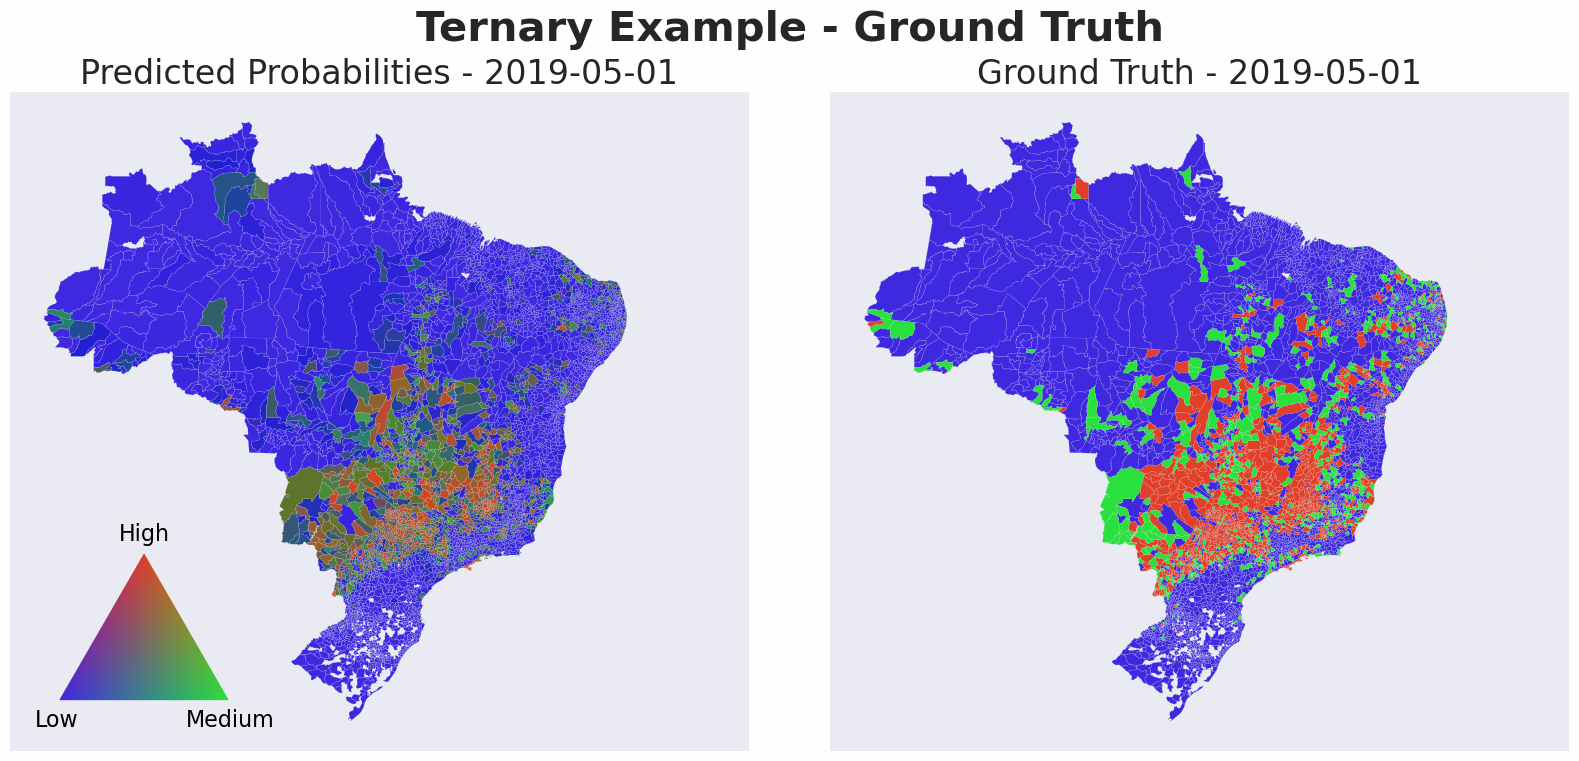

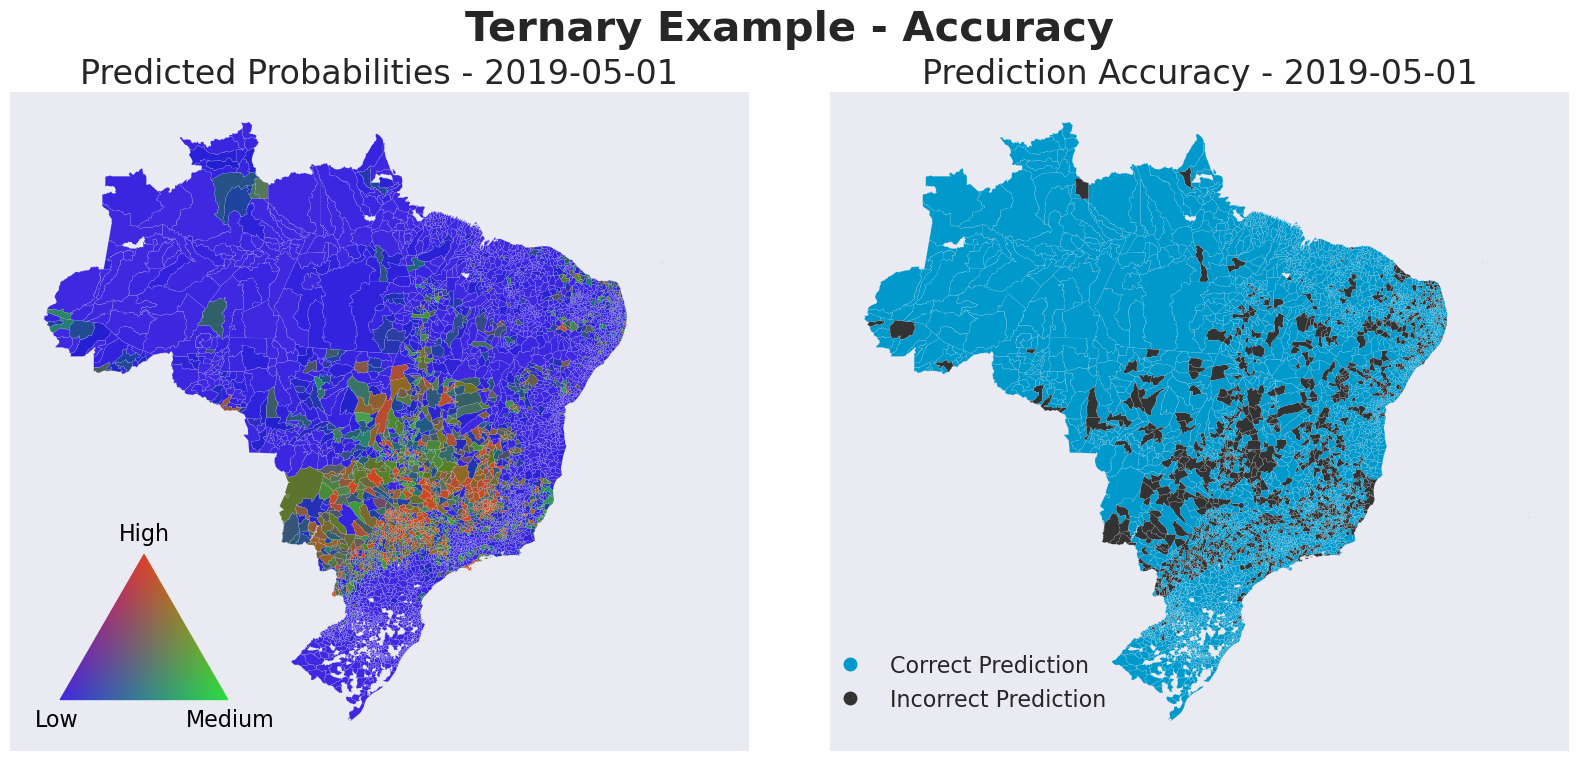

In [26]:
# Since gradient boosting classifier outputs probabilities, we can use them to create probability maps
# Binary classification can be plotted with with plot_binary function

# probabilities + ground truth
fig, ax = plot_ternary(results['results'], munis, '2019-05-01', 'Ternary Example - Ground Truth', accuracy=False)

# probabilities + accuracy
fig, ax = plot_ternary(results['results'], munis, '2019-05-01', 'Ternary Example - Accuracy', accuracy=True)

##### 3. Case Lookback Search - How many prior months of cases to include

In [ ]:
#Just going to use Gradient boosting and case lag = 1 for this. 
# Add another nested loop to perform case lag search as well
#LOOKBACK_RESULTS[cat_style][case_lookback]

#Running results for binary/ternary and simple relatives over case lags 1-4
LOOKBACK_RESULTS = {cat_style: dict() for cat_style in CAT_DICT.keys()}
LOOKBACKS = range(1, 49)
for cat_style, cat_fn in CAT_DICT.items():
    for lookback in LOOKBACKS:
        clf = HistGradientBoostingClassifier(categorical_features=['month'], random_state=42, max_iter=1000)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=cat_fn,
            cat_style=cat_style,
            case_lag=1,
            case_lookback=lookback
        )
        LOOKBACK_RESULTS[cat_style][lookback] = results

##### 4. Non-contiguous time-lag search

##### 5. Environmental feature search

##### 6. Lag-correlated municipios

##### 7. Hyperparameter search